In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm

current_dir = Path.cwd()
import sys

sys.path.append(str(current_dir.parent))
from utils import get_competition_data_path

%matplotlib inline

In [2]:
path_dict = get_competition_data_path("m5-forecasting-accuracy")
competition_path = path_dict.get("competition_path")
train_path = path_dict.get("train_path")
submission_path = path_dict.get("sample_submission_path")
calendar_path = competition_path / "calendar.csv"
sell_prices_path = competition_path / "sell_prices.csv"

In [3]:
calendar = pd.read_csv(calendar_path)
sales = pd.read_csv(train_path)
sample_submission = pd.read_csv(submission_path)
sell_prices = pd.read_csv(sell_prices_path)

In [4]:
plt.rcParams["figure.figsize"] = 14, 6
sns.set()

In [5]:
from statsmodels.tsa.stattools import kpss, adfuller

In [6]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [68]:
def plot_ma(df, ax=None):
    ma_df = df.rolling(60).mean()
    if ax:
        df.plot(color='grey', alpha=0.3, legend=False, ax=ax)
    else:
        ax = df.plot(color='grey', alpha=0.3, legend=False)
    ma_df.plot(ax=ax)
    
    return ax

## Objectives
The objective of the M5 forecasting competition is to advance the theory and practice of forecasting by identifying the method(s) that provide the most accurate point forecasts for each of the 42,840 time series of the competition. I addition, to elicit information to estimate the uncertainty distribution of the realized values of these series as precisely as possible. 
To that end, the participants of M5 are asked to provide 28 days ahead point forecasts (PFs) for all the series of the competition, as well as the corresponding median and 50%, 67%, 95%, and 99% prediction intervals (PIs).
The M5 differs from the previous four ones in five important ways, some of them suggested by the discussants of the M4  competition, as follows:
- First, it uses grouped unit sales data, starting at the product-store level and being aggregated to that of product departments, product categories, stores, and three geographical areas: the States of California (CA), Texas (TX), and Wisconsin (WI).
- Second, besides the time series data, it includes explanatory variables such as sell prices, promotions, days of the week, and special events (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter) that typically affect unit sales and could improve forecasting accuracy.
- Third, in addition to point forecasts, it assesses the distribution of uncertainty, as the participants are asked to provide information on nine indicative quantiles.
- Fourth, instead of having a single competition to estimate both the point forecasts and the uncertainty distribution, there will be two parallel tracks using the same dataset, the first requiring 28 days ahead point forecasts and the second 28 days ahead probabilistic forecasts for the median and four prediction intervals (50%, 67%, 95%, and 99%).
- Fifth, for the first time it focuses on series that display intermittency, i.e., sporadic demand including zeros.

## Datasets info
The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated.  The products are sold across ten stores, located in three States (CA, TX, and WI)

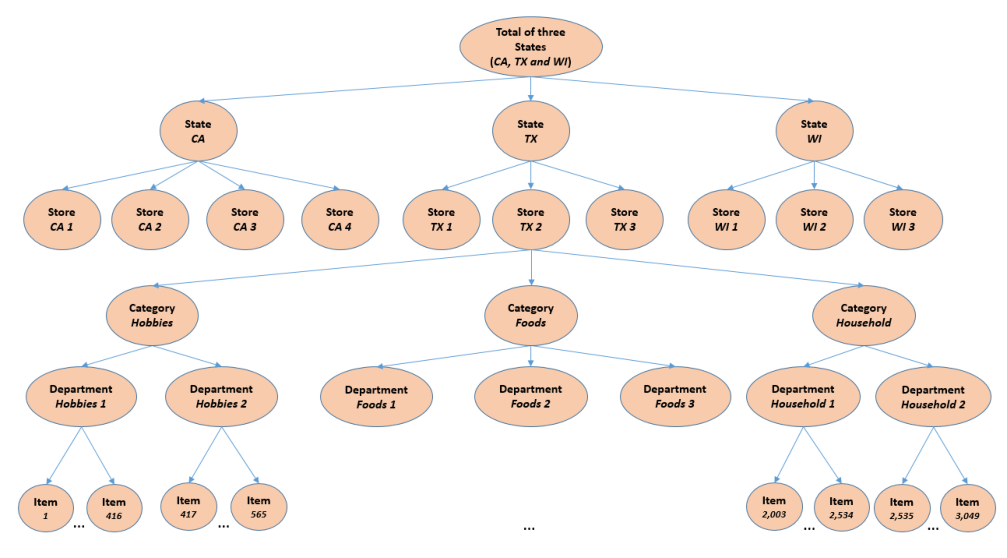

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sns.set()
plt.rcParams["figure.figsize"] = 20, 10

img = mpimg.imread("../data/m5-forecasting-accuracy/m5-forecasting-hierarchical.png")
imgplot = plt.imshow(img)
plt.grid(False)
plt.axis("off")
plt.show()

In [8]:
plt.rcParams["figure.figsize"] = 14, 6

In [9]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## File 1: “calendar.csv” 
Contains information about the dates the products are sold.
- date: The date in a “y-m-d” format.
- wm_yr_wk: The id of the week the date belongs to.
- weekday: The type of the day (Saturday, Sunday, …, Friday).
- wday: The id of the weekday, starting from Saturday.
- month: The month of the date.
- year: The year of the date.
- event_name_1: If the date includes an event, the name of this event.
- event_type_1: If the date includes an event, the type of this event.
- event_name_2: If the date includes a second event, the name of this event.
- event_type_2: If the date includes a second event, the type of this event.
- snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed. <br>
(Supplemental Nutrition Assistance Program (SNAP), is the program formerly known as food stamps)

In [10]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## File 2: “sales_train.csv” 
Contains the historical daily unit sales data per product and store.
- item_id: The id of the product.
- dept_id: The id of the department the product belongs to.
- cat_id: The id of the category the product belongs to.
- store_id: The id of the store where the product is sold.
- state_id: The State where the store is located.
- d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 

In [11]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## File 3: “sell_prices.csv”
Contains information about the price of the products sold per store and date.
- store_id: The id of the store where the product is sold. 
- item_id: The id of the product.
- wm_yr_wk: The id of the week.
- sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  

In [12]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


## Exploratory 

### Explore the relationship on an aggregated level: total sales

Get the total sales, removing the outliers sales on Xmas

In [13]:
d_dict = dict(zip(calendar["d"], calendar["date"]))
d_cols = sales.columns[6:].tolist()
date_cols = sales.columns[6:].map(d_dict).tolist()
all_cols = sales.columns[:6].tolist() + date_cols

In [14]:
sales_w_dates = sales.copy()
sales_w_dates.columns = all_cols

total_sales = sales_w_dates.iloc[:, 6:].copy()
total_sales = total_sales.sum(axis=0)

In [15]:
outliers = total_sales.loc[total_sales < 10000].index.tolist()
outliers_d = calendar.query('date in @outliers')['d'].tolist()

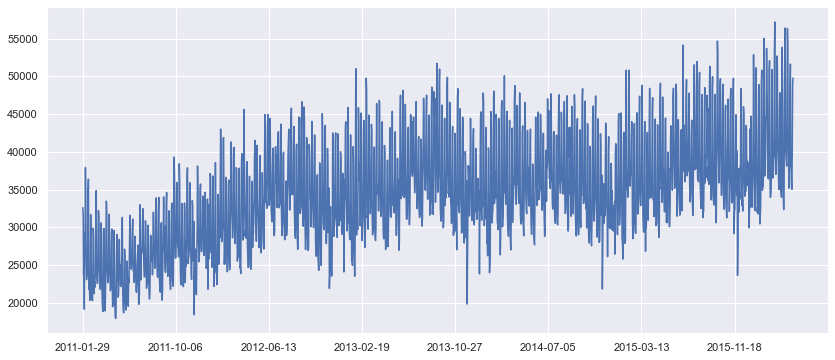

In [16]:
sales = sales.drop(columns=outliers_d)
total_sales = total_sales.loc[~total_sales.index.isin(outliers)]
d_cols = sales.columns[6:].tolist()
date_cols = sales.columns[6:].map(d_dict).tolist()
total_sales.plot()

total_sales = total_sales.reset_index()
total_sales.columns = ['date', 'sales']

#### Relationship between calendar and total sales
- day
- weekday
- month
- quarter
- snap
- event
- lag event

In [17]:
sales_w_calendar = total_sales.merge(calendar, on='date', how='left').set_index('date')
sales_w_calendar.index = pd.to_datetime(sales_w_calendar.index)
sales_w_calendar['quarter'] = sales_w_calendar.index.quarter

sales_w_calendar.head()

,sales,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter
date,,,,,,,,,,,,,,,
2011-01-29,32631,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1
2011-01-30,31749,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1
2011-01-31,23783,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1
2011-02-01,25412,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1
2011-02-02,19146,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1


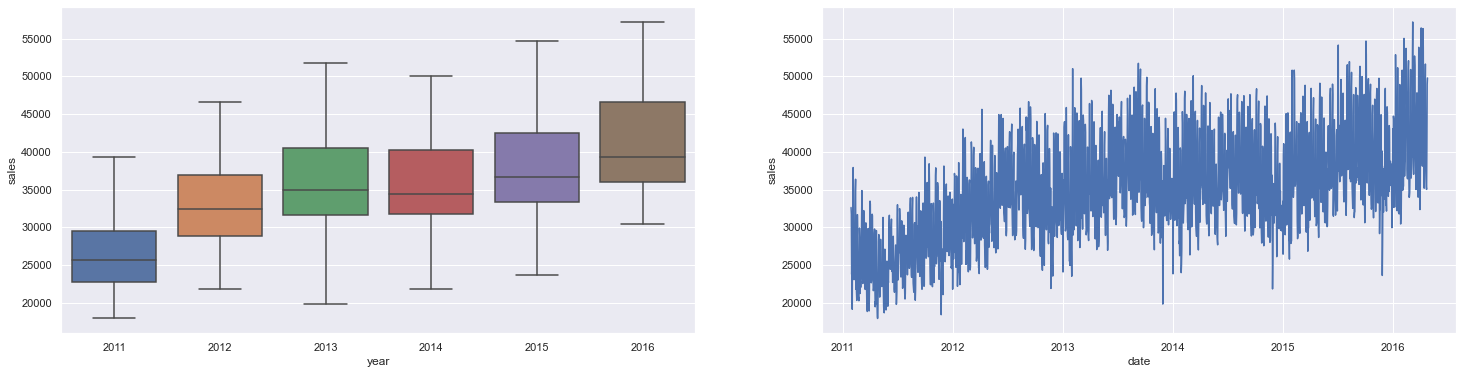

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

sns.boxplot(data=sales_w_calendar, x='year', y='sales', ax=ax1)

sns.lineplot(data=sales_w_calendar, y='sales', x=sales_w_calendar.index, palette='coolwarm', ax=ax2)

- Sales are on an upward trend over the year

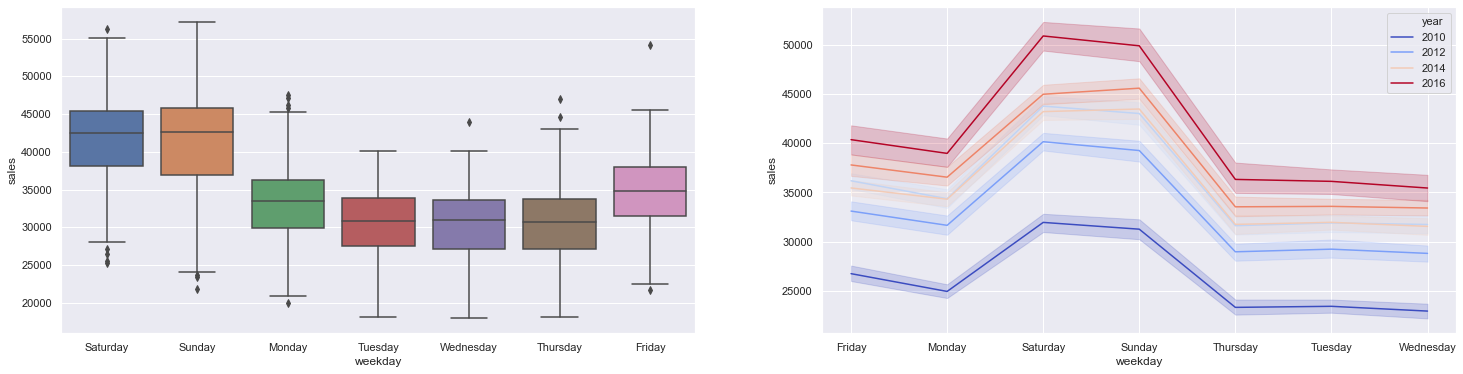

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

sns.boxplot(data=sales_w_calendar, x='weekday', y='sales', ax=ax1)

sns.lineplot(data=sales_w_calendar, y='sales', x='weekday', hue='year', palette='coolwarm', ax=ax2)

- Sales are higher on the weekend (Saturday and Sunday), which makes sense as people have more time to go shopping

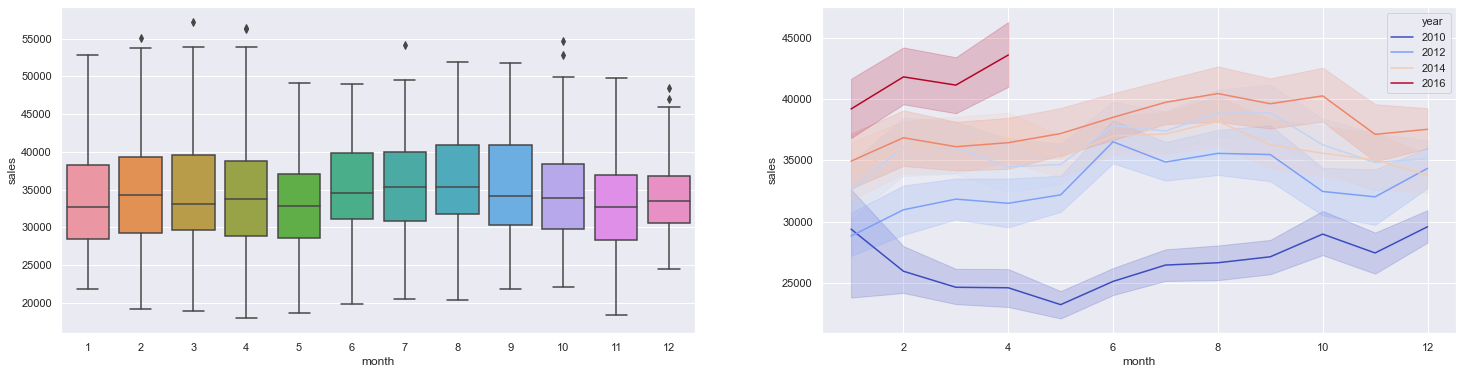

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

sns.boxplot(data=sales_w_calendar, x='month', y='sales', ax=ax1)

sns.lineplot(data=sales_w_calendar, y='sales', x='month', hue='year', palette='coolwarm', ax=ax2)

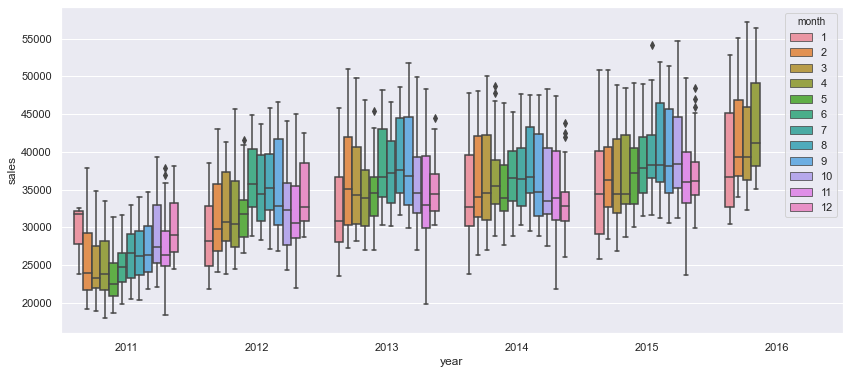

In [21]:
sns.boxplot(data=sales_w_calendar, x='year', y='sales', hue='month')

- Sales appear to be higher during the summer, then go down slightly in fall, and pick up again end of year/start of year

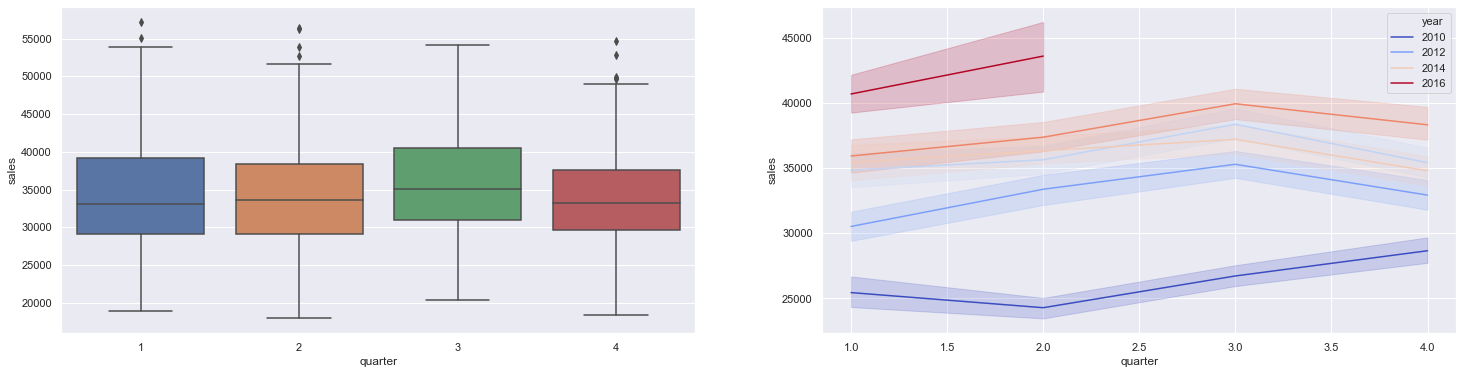

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

sns.boxplot(data=sales_w_calendar, x='quarter', y='sales', ax=ax1)

sns.lineplot(data=sales_w_calendar, y='sales', x='quarter', hue='year', palette='coolwarm', ax=ax2)

- These charts reiterate the point above, i.e. sales are higher in quarter 1 and 3

- Now, let's see if an event having any effect on total sales
- First, check if the week having an event having higher sales than normal week

In [23]:
sales_w_calendar['event'] = sales_w_calendar['event_name_1'].notnull() 
weekly_sales = sales_w_calendar.resample("W")[['sales', 'event']].sum()
weekly_sales['event'] = weekly_sales['event'].where(weekly_sales['event'] == 0, 1)
weekly_sales['event_t1'] = weekly_sales['event'].shift(-1)
sales_w_calendar = sales_w_calendar.merge(weekly_sales[['event_t1']], on='date', how='left')
sales_w_calendar['event_t1'] = sales_w_calendar['event_t1'].ffill()

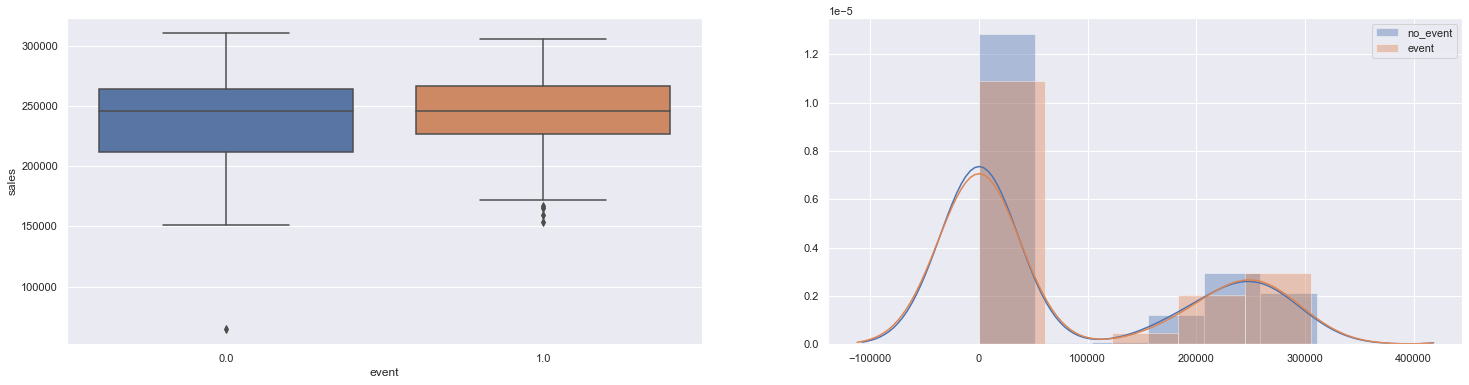

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

sns.boxplot(data=weekly_sales, y='sales', x='event', ax=ax1)
sns.distplot(weekly_sales.query('event == 0'), ax=ax2, label='no_event')
sns.distplot(weekly_sales.query('event == 1'), ax=ax2, label='event')
plt.legend()

- Weeks with events don't seem to have a significant difference in sales compared to weeks without events
- Maybe people will buy a week before, in expectation of the event?

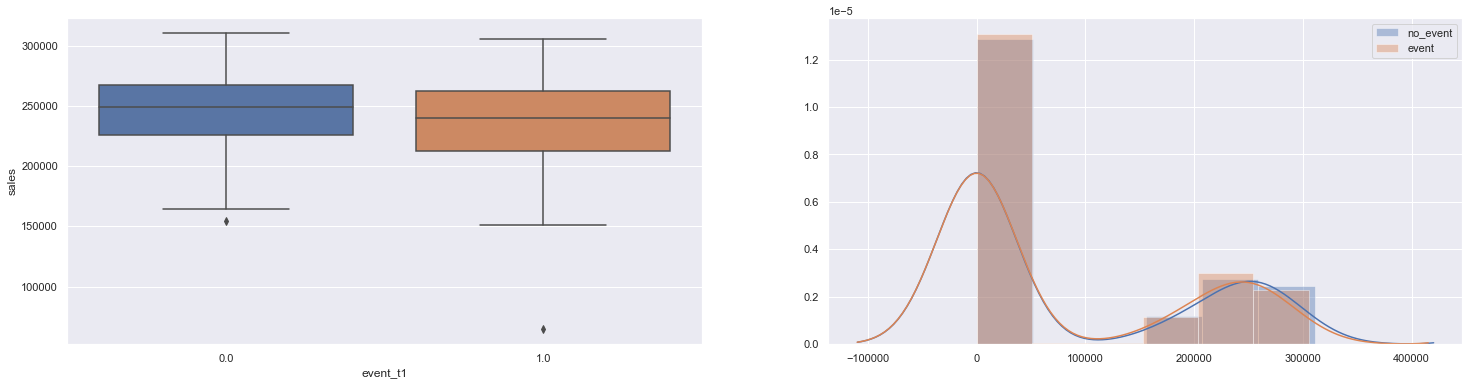

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

sns.boxplot(data=weekly_sales, y='sales', x='event_t1', ax=ax1)
sns.distplot(weekly_sales.query('event_t1 == 0'), ax=ax2, label='no_event')
sns.distplot(weekly_sales.query('event_t1 == 1'), ax=ax2, label='event')
plt.legend()

- Doesn't seem to have any significant effect as well

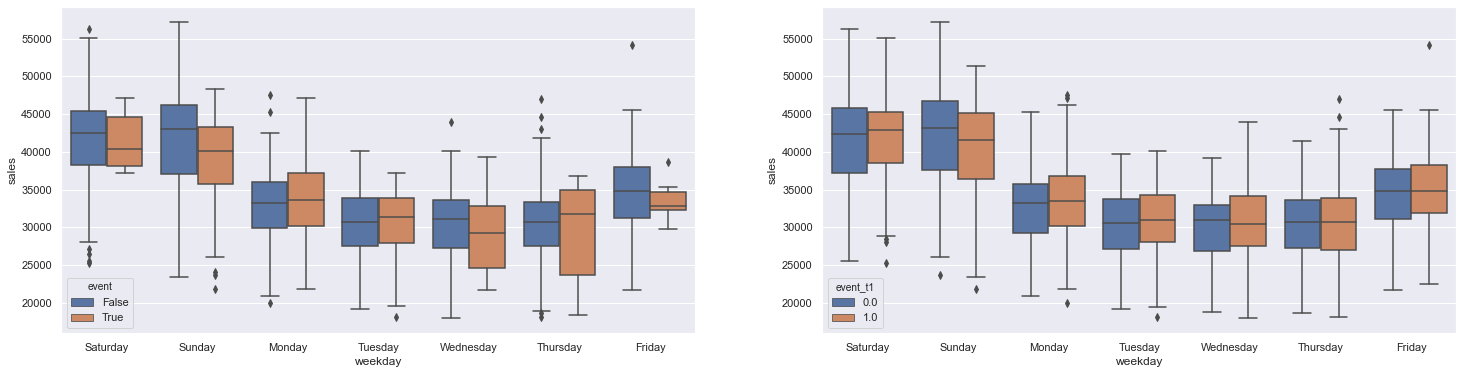

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
sns.boxplot(data=sales_w_calendar, x='weekday', y='sales', hue='event_t1', ax=ax2)
sns.boxplot(data=sales_w_calendar, x='weekday', y='sales', hue='event', ax=ax1)

- Overall, events or lagged events don't have a significant effect on sales
- How about snap?

In [27]:
sales_w_calendar['snap'] = (sales_w_calendar[['snap_CA', 'snap_TX', 'snap_WI']] == 1).any(axis=1)

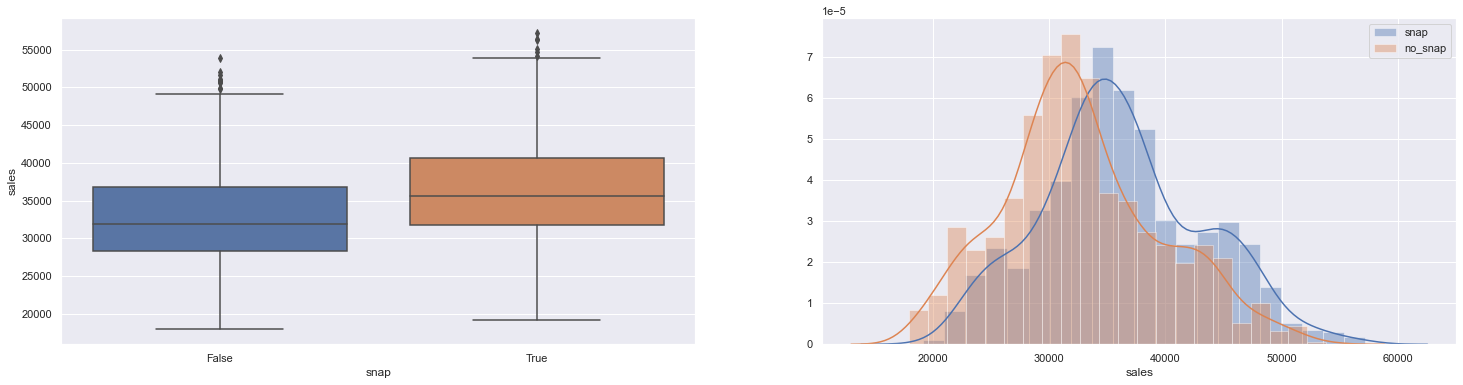

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

sns.boxplot(data=sales_w_calendar, x='snap', y='sales', ax=ax1)

sns.distplot(sales_w_calendar.query('snap == 1')['sales'], label='snap', ax=ax2)
sns.distplot(sales_w_calendar.query('snap == 0')['sales'], label='no_snap', ax=ax2)
plt.legend()

- Snap, on the other hand, significantly increase sale volumne.

### Relationship between total sales and itself
- Lag
    - 1
    - 7
    - 28
    - 365
    

In [29]:
total_sales = total_sales.set_index('date')

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

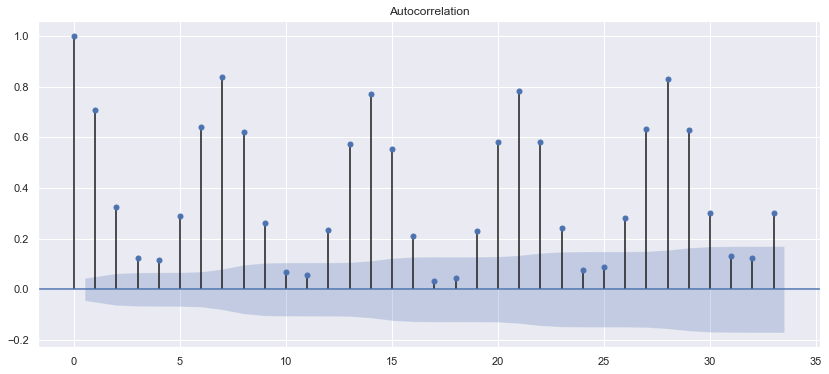

In [31]:
plot_acf(total_sales);

- Sales are heavily correlated with their past volumes
- Seasonality -> weekly sales are highly auto correlated
- Lag 1, 7, and 28 might be good candidates for lagged features

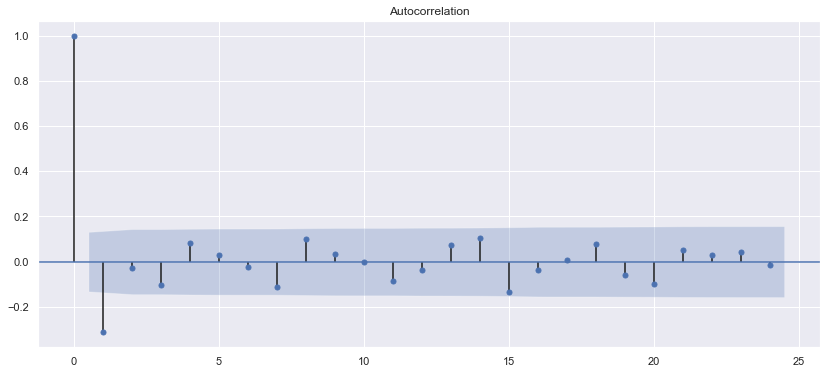

In [32]:
plot_acf(weekly_sales['sales'].diff().dropna().diff(52).dropna());

- Looking at weekly autocorrelation, after taking the first difference and 52th difference, we are (almost) able to achieve stationarity
- So lag 265 might also be a good idea for lagged features

### Explore the relationship on category level

### Relationship between selling prices and category sales
- Current prices
- Lag prices
- Changes in prices
- Lagged changes in prices

In [33]:
cat_sales = sales_w_dates[['cat_id'] + date_cols].copy()
cat_sales = cat_sales.groupby('cat_id').sum().T

dept_sales = sales_w_dates[['dept_id'] + date_cols].copy()
dept_sales = dept_sales.groupby('dept_id').sum().T

In [34]:
map_dept = dict(zip(sales['item_id'], sales['dept_id']))
map_cat = dict(zip(sales['item_id'], sales['cat_id']))
map_date = calendar.groupby('wm_yr_wk')['date'].first().to_dict()

In [35]:
sell_prices = sell_prices.assign(
    dept_id=sell_prices['item_id'].map(map_dept),
    cat_id=sell_prices['item_id'].map(map_cat),
    date=sell_prices['wm_yr_wk'].map(map_date),
)
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,dept_id,cat_id,date
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1,HOBBIES,2013-07-13
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1,HOBBIES,2013-07-20
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1,HOBBIES,2013-07-27
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1,HOBBIES,2013-08-03
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1,HOBBIES,2013-08-10


In [56]:
cat_prices = sell_prices.pivot_table(index='date', columns='cat_id', values='sell_price', aggfunc='mean')
# dept_prices = sell_prices.pivot_table(index='date', columns='dept_id', values='sell_price', aggfunc='mean')

cat_prices.index = pd.to_datetime(cat_prices.index)
# dept_prices.index = pd.to_datetime(dept_prices.index)

cat_sales_p = cat_sales.join(cat_prices, rsuffix=('_price')).ffill()
# dept_sales_p = dept_sales.join(dept_prices, rsuffix=('_price')).ffill()

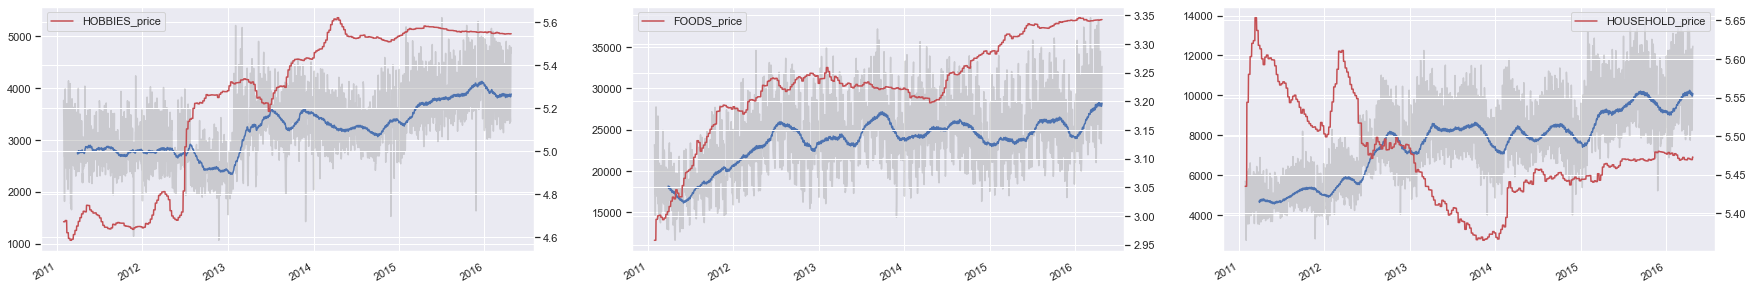

In [69]:
fig, (ax1, ax3, ax5) = plt.subplots(1, 3, figsize=(30, 5))

plot_ma(cat_sales_p['HOBBIES'], ax=ax1)
ax2 = ax1.twinx()
cat_sales_p['HOBBIES_price'].plot(ax=ax2, color='r', legend=True)

plot_ma(cat_sales_p['FOODS'], ax=ax3)
ax4 = ax3.twinx()
cat_sales_p['FOODS_price'].plot(ax=ax4, color='r', legend=True)

plot_ma(cat_sales_p['HOUSEHOLD'], ax=ax5)
ax6 = ax5.twinx()
cat_sales_p['HOUSEHOLD_price'].plot(ax=ax6, color='r', legend=True)

- The charts above show the time series of average prices for each category, as well as their average sales and their moving averages.
- These seems to be no correlation between the level of prices and the volumnes of sales.
- Let's investigate the relationship between the changes in prices and the changes in sales. A decrease in prices could lead to an increase in sales?

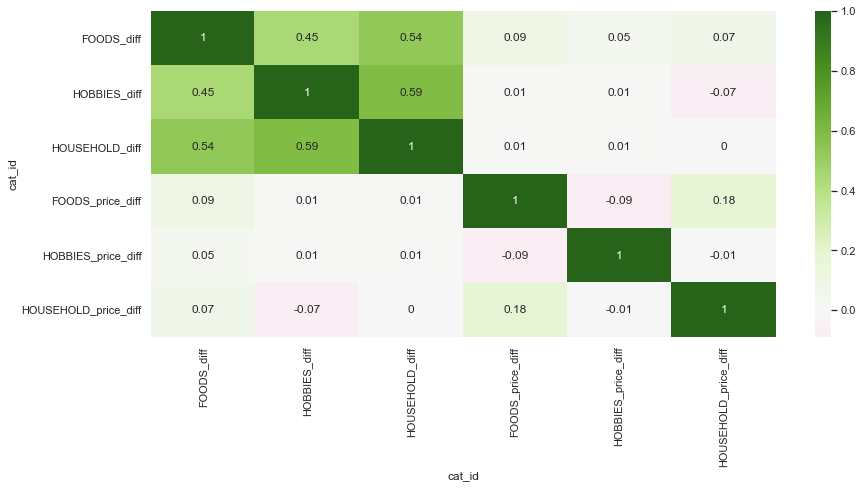

In [71]:
cat_diff = cat_sales_p.resample('W').last().diff().add_suffix('_diff')
cat_corr = cat_diff.corr().round(2)
sns.heatmap(cat_corr, annot=True, cmap='PiYG', center=0)

- The correlation between the changes in prices and those of sales are very small
- Let's turn to lagged prices. A known decrease in prices (through a prospectus?) could lead to an increase in sales?

In [81]:
cat_sales_p1 = cat_sales.join(cat_prices.shift(-1), rsuffix=('_price')).ffill()
cat_sales_p1.tail()

cat_id,FOODS,HOBBIES,HOUSEHOLD,FOODS_price,HOBBIES_price,HOUSEHOLD_price
2016-04-20,23632,3472,8239,3.342724,5.546591,5.472873
2016-04-21,23317,3353,8363,3.342724,5.546591,5.472873
2016-04-22,26704,4085,9728,3.342724,5.546591,5.472873
2016-04-23,31927,4787,12248,3.343752,5.546152,5.472376
2016-04-24,32654,4683,12458,3.343752,5.546152,5.472376


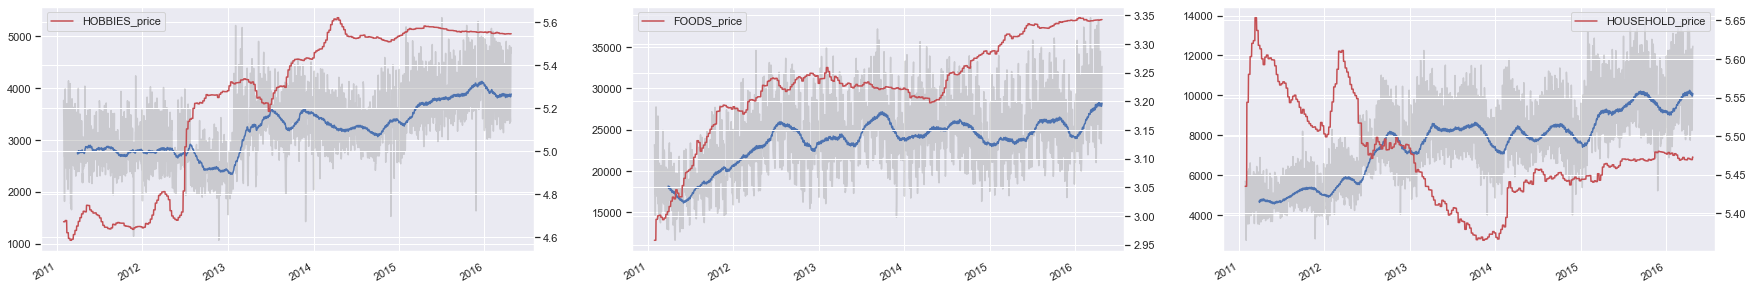

In [82]:
fig, (ax1, ax3, ax5) = plt.subplots(1, 3, figsize=(30, 5))

plot_ma(cat_sales_p1['HOBBIES'], ax=ax1)
ax2 = ax1.twinx()
cat_sales_p['HOBBIES_price'].plot(ax=ax2, color='r', legend=True)

plot_ma(cat_sales_p1['FOODS'], ax=ax3)
ax4 = ax3.twinx()
cat_sales_p['FOODS_price'].plot(ax=ax4, color='r', legend=True)

plot_ma(cat_sales_p1['HOUSEHOLD'], ax=ax5)
ax6 = ax5.twinx()
cat_sales_p['HOUSEHOLD_price'].plot(ax=ax6, color='r', legend=True)

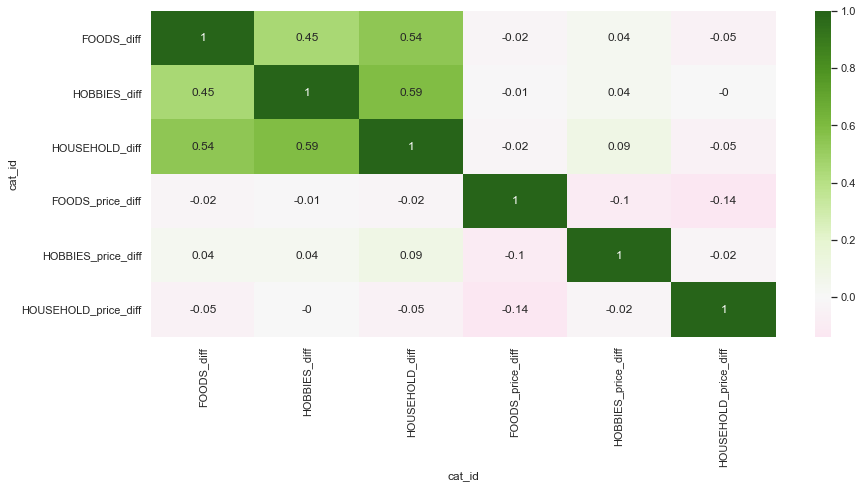

In [83]:
cat_diff = cat_sales_p1.resample('W').last().diff().add_suffix('_diff')
cat_corr = cat_diff.corr().round(2)
sns.heatmap(cat_corr, annot=True, cmap='PiYG', center=0)

- Doesn't seem to be any better
- Maybe prices don't affect sales?

### Relationship between events/holidays and category sales
- Events might not have a distinct effect on total sales, but it could affect some certain categories, e.g. Foods

In [87]:
cat_sales_w_event = cat_sales.join(sales_w_calendar[['event', 'event_t1']])

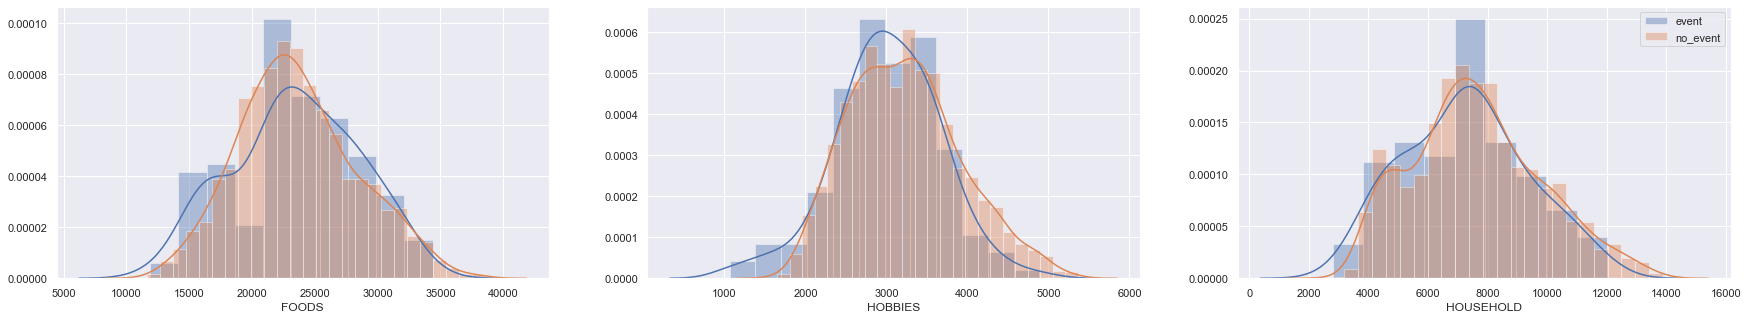

In [92]:
fig, (ax1, ax3, ax5) = plt.subplots(1, 3, figsize=(30, 5))

sns.distplot(cat_sales_w_event.query('event == True')['FOODS'], label='event', ax=ax1)
sns.distplot(cat_sales_w_event.query('event == False')['FOODS'], label='no_event', ax=ax1)

sns.distplot(cat_sales_w_event.query('event == True')['HOBBIES'], label='event', ax=ax3)
sns.distplot(cat_sales_w_event.query('event == False')['HOBBIES'], label='no_event', ax=ax3)

sns.distplot(cat_sales_w_event.query('event == True')['HOUSEHOLD'], label='event', ax=ax5)
sns.distplot(cat_sales_w_event.query('event == False')['HOUSEHOLD'], label='no_event', ax=ax5)

plt.legend()

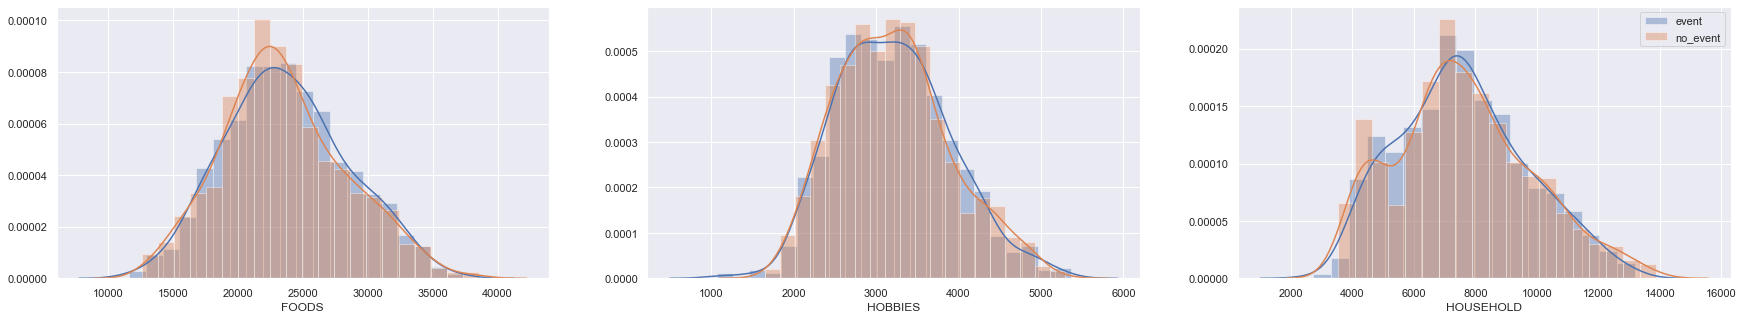

In [93]:
fig, (ax1, ax3, ax5) = plt.subplots(1, 3, figsize=(30, 5))

sns.distplot(cat_sales_w_event.query('event_t1 == 1')['FOODS'], label='event', ax=ax1)
sns.distplot(cat_sales_w_event.query('event_t1 == 0')['FOODS'], label='no_event', ax=ax1)

sns.distplot(cat_sales_w_event.query('event_t1 == 1')['HOBBIES'], label='event', ax=ax3)
sns.distplot(cat_sales_w_event.query('event_t1 == 0')['HOBBIES'], label='no_event', ax=ax3)

sns.distplot(cat_sales_w_event.query('event_t1 == 1')['HOUSEHOLD'], label='event', ax=ax5)
sns.distplot(cat_sales_w_event.query('event_t1 == 0')['HOUSEHOLD'], label='no_event', ax=ax5)

plt.legend()

- No better as well